# 📊 Emotion Classification Data Preparation (Persian Tweets)

## 📌 Introduction

In this project, we build a clean, unified dataset for **emotion classification in Persian tweets**, aiming to fine-tune a BERT-based model.

We use and combine **three different publicly available datasets**:

- **Persian Short Emotion Dataset** : `https://github.com/vkiani/ShortPersianEmo`
- **EmoPars** : `https://github.com/nazaninsbr/Persian-Emotion-Detection`
- **ArmanEmo** : `https://github.com/Arman-Rayan-Sharif/arman-text-emotion/tree/main/dataset`

These datasets are sourced from Persian Twitter and annotated for various emotional states.

---

## 🎯 Goal

The main objective is to:
- Merge these datasets into a single, consistent format.
- Clean and preprocess the text data.
- Analyze the data distribution.
- Optionally resample the data to handle class imbalance.
- Save the final dataset in two formats:
  - As a Pandas DataFrame (`.csv`)
  - As a Hugging Face `DatasetDict` (for easy integration with 🤗 Transformers)

---

## ⚠️ Note on Resampling

Although we implemented **resampling techniques** (like oversampling/undersampling) to address **class imbalance**, we eventually **commented out those steps**.

Instead, during training, we found that **using a weighted loss function** (e.g., `CrossEntropyLoss(weight=...)`) yielded better performance and generalization.



## 📥 Step 1: Loading & Formatting Datasets

In this section, we load each of the three Persian Twitter emotion datasets one by one:

- **Persian Short Emotion**
- **EmoPars**
- **ArmanEmo**

Our goal is to convert them into a **unified structure** with the following columns:
- `text`: the Persian tweet text
- `label`: numerical label (0 to 5)
- `label_name`: corresponding string label from:
  
  ```python
  emotion_labels = ['ANGRY', 'FEAR', 'HAPPY', 'HATE', 'SAD', 'SURPRISE']


  ### 📊 Label Distribution Check

After formatting each dataset, we visualize or print the **label distribution** to better understand class balance. This helps in guiding future decisions like resampling, class weighting, or data augmentation.

---

  ### 🔗 Final Step: Merge All Datasets

Once each dataset has been cleaned and standardized (with the same column format: `text`, `label`, `label_name`), we **concatenate** them into a single unified dataset.

This merged dataset combines the strengths of:
- **Persian Short Emotion**
- **Filtered EmoPars** (single-label only)
- **ArmanEmo**


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# conect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ArmanEmo datast

In [ ]:
arman_df = pd.read_excel("/content/drive/My Drive/BERT/Data/raw/ArmanEmo/train.xlsx", header=None)
arman_df.columns = ["text", "label_name"]
arman_df = arman_df[arman_df['label_name'] != 'OTHER'].reset_index(drop=True)
arman_df.head()

,text,label_name
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,اين وضع ب طرز خنده داري گريه داره ...,SAD
4,خب من رسما از یک نفر متنفرم،چون از گربه بدش می...,HATE


In [ ]:
print(arman_df['label_name'].unique())

['SAD' 'HATE' 'FEAR' 'ANGRY' 'HAPPY' 'SURPRISE' nan]


In [ ]:
# Define your emotion labels and their IDs
emotion_labels = ['ANGRY', 'FEAR', 'HAPPY', 'HATE', 'SAD', 'SURPRISE']
label2id = {label: idx for idx, label in enumerate(emotion_labels)}

# For the other dataset (let's call it df_other) which also has 'text' and 'label' columns
arman_df['label'] = arman_df['label_name'].map(label2id)
arman_df.head()

,text,label_name,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD,4.0
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE,3.0
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD,4.0
3,اين وضع ب طرز خنده داري گريه داره ...,SAD,4.0
4,خب من رسما از یک نفر متنفرم،چون از گربه بدش می...,HATE,3.0


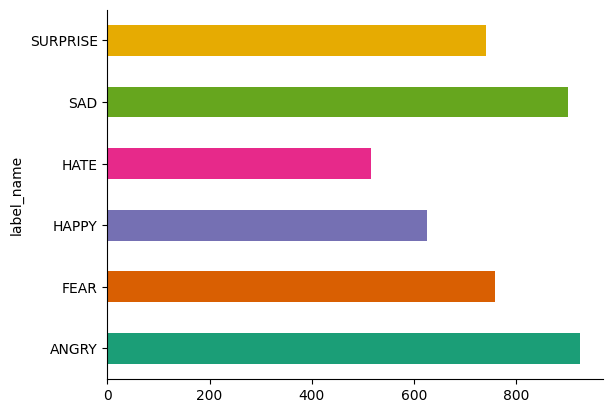

In [ ]:
arman_df.groupby('label_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
arman_df.shape

(4471, 3)

### EmoPars dataset


###  EmoPars Special Handling

The **EmoPars dataset** is initially **multi-label**, meaning one tweet can have multiple emotion tags. Since our model expects **single-label classification**, we apply the following strategy:

- For each tweet, we calculate the **difference between the highest label value and the others**.
- If the **dominant label is at least 3 units greater than all other labels**, we consider it a **confident single-label case** and keep the tweet.
- Tweets that don't meet this threshold are **excluded**, as they introduce ambiguity.

This strategy allows us to retain high-quality examples from EmoPars while avoiding uncertain or noisy labels.


In [ ]:
pars_df = pd.read_csv("/content/drive/My Drive/BERT/Data/raw/EmoPars/dataset.csv", header=None)
pars_df.head()

,0,1,2,3,4,5,6
0,text,Anger,Fear,Happiness,Hatred,Sadness,Wonder
1,کرونا رو شکست میدهیم؟\nمرحله بعد چه گوهی میخوا...,4,3,1,3,3,4
2,اگر در چند ماه اخیر تصمیم داشته اید وارد بورس ...,2,4,1,2,4,2
3,یکی از پدرسوختگی های #برانداز اینه که ظاهرا ژس...,5,3,2,4,5,2
4,یکی از دوستای دبستانم,1,0,0,1,0,0


In [ ]:
pars_df.columns = ['text'] + emotion_labels
pars_df = pars_df.drop([0])
pars_df.head()

,text,ANGRY,FEAR,HAPPY,HATE,SAD,SURPRISE
1,کرونا رو شکست میدهیم؟\nمرحله بعد چه گوهی میخوا...,4,3,1,3,3,4
2,اگر در چند ماه اخیر تصمیم داشته اید وارد بورس ...,2,4,1,2,4,2
3,یکی از پدرسوختگی های #برانداز اینه که ظاهرا ژس...,5,3,2,4,5,2
4,یکی از دوستای دبستانم,1,0,0,1,0,0
5,@username اینقدر گرفتار مسایل میشی که تخصص از ...,2,1,0,1,0,4


In [ ]:
def is_ambiguous(row):
    sorted_scores = row.sort_values(ascending=False).dropna()
    if len(sorted_scores) < 2:
        return False
    return (sorted_scores.iloc[0] - sorted_scores.iloc[1]) < 3

In [ ]:
emotion_cols = pars_df.columns[1:]  # all columns except 'text'
pars_df[emotion_cols] = pars_df[emotion_cols].apply(pd.to_numeric, errors='coerce')
ambiguous_mask = pars_df[emotion_cols].apply(is_ambiguous, axis=1)
n_ambiguous = ambiguous_mask.sum()
print(f"Removing {n_ambiguous} ambiguous rows out of {len(pars_df)} total.")


Removing 29654 ambiguous rows out of 30000 total.


In [ ]:
pars_df = pars_df.loc[~ambiguous_mask].reset_index(drop=True)

In [ ]:
# convert parsEmo dataset to classification version

emotion_labels = ['ANGRY', 'FEAR', 'HAPPY', 'HATE', 'SAD', 'SURPRISE']

# Step 0: Rename columns to match emotion labels
pars_df.columns = ['text'] + emotion_labels

# Step 1: Get column with max score per row
emotion_cols = emotion_labels
max_emotion_cols = pars_df[emotion_cols].idxmax(axis=1)

# Step 2: Map column name to label index
label_map = {label: idx for idx, label in enumerate(emotion_labels)}
pars_df['label'] = max_emotion_cols.map(label_map)

# Step 3: Add label name using list lookup
pars_df['label_name'] = pars_df['label'].map(lambda x: emotion_labels[x])

# Step 4: Keep only text, label_id, and label
pars_df = pars_df[['text', 'label', 'label_name']]


In [ ]:
pars_df.head()

,text,label,label_name
0,به سلامتی و عاقبت بخیری ان‌شاءالله,2,HAPPY
1,اون چارسانتیه یوزی نی.دول آقاتونه.زیر پتو تویی...,3,HATE
2,بچه ها اگه کانادا گفته سه ماه دیگه قرنطینه صد ...,5,SURPRISE
3,با توجه به ریدین که نه در ایران که در منطقه و...,4,SAD
4,من ۲۴ سالمه و یکی از هم دانشگاهیام که ۵ سال از...,4,SAD


In [ ]:
pars_df.shape

(346, 3)

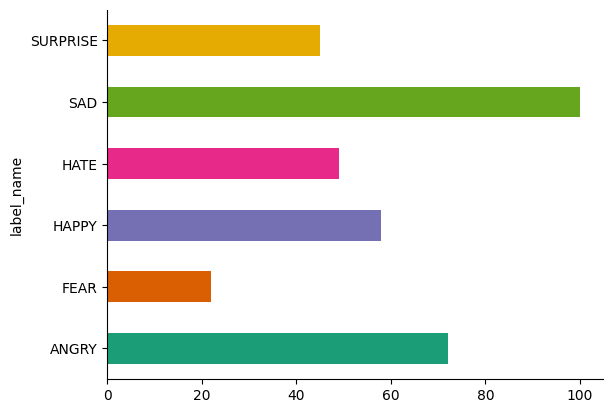

In [ ]:
pars_df.groupby('label_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Short Persian Emo

In [ ]:
short_df = pd.read_excel("/content/drive/My Drive/BERT/Data/row/ShortPersianEmo/train.xlsx", header=None)
short_df.columns = ["text", "label_name"]
short_df = short_df[short_df['label_name'] != 'OTHER'].reset_index(drop=True)
short_df.head()

,text,label_name
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD


In [ ]:
print(short_df['label_name'].unique())

['SAD' 'HAPPY' 'ANGRY' 'FEAR']


In [ ]:
# For the other dataset (let's call it df_other) which also has 'text' and 'label' columns
short_df['label'] = short_df['label_name'].map(label2id)
short_df.head()

,text,label_name,label
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD,4
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD,4
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY,2
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY,0
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD,4


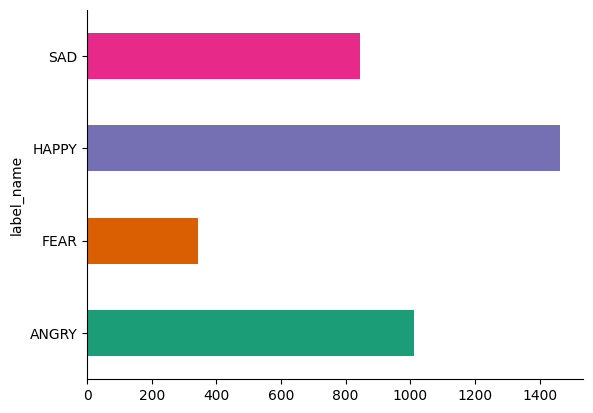

In [ ]:
short_df.groupby('label_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df = pd.concat([short_df,pars_df,arman_df], ignore_index=True)
print(df.shape)
df.head()

(8478, 3)


,text,label_name,label
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD,4.0
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD,4.0
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY,2.0
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY,0.0
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD,4.0


## 🧹 Step 2: Cleaning the Dataset

Before using the dataset for model training or analysis, we apply several cleaning steps to ensure **text quality** and **label consistency**.



###  1. Remove Duplicates
We start by removing **duplicate rows** based on the `text` column to avoid bias caused by repeated tweets.

In [ ]:
df.duplicated().any()

np.True_

In [ ]:
duplicates = df[df.duplicated()]
duplicates

,text,label_name,label
6731,بی ادب,ANGRY,0.0
6742,بی ادب,ANGRY,0.0
7092,بی ادب,ANGRY,0.0
7256,بی ادب,ANGRY,0.0
7318,وحشتناکه,FEAR,1.0
7330,چه جالب,SURPRISE,5.0
7407,خیلی وحشتناکه,FEAR,1.0
7428,چه وحشتناک,FEAR,1.0
7437,بی ادب,ANGRY,0.0
7623,از کجا میدونی؟,SURPRISE,5.0


In [ ]:
df = df.drop_duplicates(subset=["text", "label"])
df.shape

(8451, 3)

###  2. Remove Null/Empty Values
We check for and **drop rows with null or missing values**


In [ ]:
df = df.dropna(subset=["text"])  # Clean up NaNs
df = df[df["text"].str.strip() != ""]  # Remove empty strings

In [ ]:
df.isnull().sum()

,0
text,0
label_name,2
label,2


In [ ]:
df = df.dropna(subset=['label','label_name'])

In [ ]:
df.isnull().sum()

,0
text,0
label_name,0
label,0



---

### 3. Text Normalization & Cleaning

To standardize the Persian text, we use a combination of:
- **Parsivar** for normalization
- **Regex and string replacements** for deeper cleaning

Here’s what the full pipeline does:

#### ✔ Parsivar Normalization
Uses `Parsivar.Normalizer` to:
- Correct spelling spacing
- Apply statistical normalization to Persian words

#### ✔ Arabic to Persian Character Replacement
Replaces Arabic characters like `ك`, `ي`, `ؤ` with their Persian equivalents (`ک`, `ی`, `و`) to unify the script.

#### ✔ Remove Diacritics
Strips all **Tashkeel** (e.g., `َ`, `ُ`, `ّ`) using Unicode regex ranges.

#### ✔ Remove Unwanted Elements
Cleans the text of:
- URLs (`https://...`)
- Mentions (`@user`)
- Hashtags (`#topic`)
- Emojis
- Latin punctuations and digits
- Extra whitespace


In [ ]:
!pip install parsivar
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 24.1 MB/s eta 0:00:00


In [ ]:
from parsivar import Normalizer, POSTagger
import re
import emoji


# === Initialize Parsivar tools ===
normalizer = Normalizer(statistical_space_correction=True)

# === Processing function using Parsivar ===
def process_with_parsivar(text):
    text = str(text)

    # Normalize
    text = normalizer.normalize(text)

    return text


# === Persian text normalization ===
def normalize_persian(text):
    replacements = {
        'ي': 'ی',
        'ك': 'ک',
        'ؤ': 'و',
        'إ': 'ا',
        'أ': 'ا',
        'ة': 'ه',
        'ۀ': 'ه',
        'ء': '',
    }
    for arabic_char, persian_char in replacements.items():
        text = text.replace(arabic_char, persian_char)
    return text

# === Remove diacritics (tashkeel) ===
def remove_diacritics(text):
    # Arabic diacritics (Fathah, Dammah, etc.)
    arabic_diacritics = re.compile(r'[\u0610-\u061A\u064B-\u065F\u0670]')
    return arabic_diacritics.sub('', text)

# === Remove URLs, mentions, hashtags, emojis, punctuation ===
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)            # Remove URLs
    text = re.sub(r'@\w+', '', text)                    # Remove mentions
    text = re.sub(r'#\w+', '', text)                    # Remove hashtags
    text = emoji.replace_emoji(text, replace='')        # Remove emojis
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)    # Remove Latin punctuations
    text = re.sub(r'\d+', '', text)                     # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()            # Remove extra spaces
    return text

# === Combine all into a full cleaning function ===
def preprocess_persian_text(text):
    text = str(text)
    text = process_with_parsivar(text)
    text = normalize_persian(text)
    text = remove_diacritics(text)
    text = clean_text(text)
    return text



df['text'] = df['text'].apply(preprocess_persian_text)

print(df['text'])

0          کی گفته مرد گریهنمیکنه ؟؟ سیلم امشب سیل اصفهان
1       تنهاییم شبیهتنهاییهظهرایبچگیمشده وقتی که همه م...
2                  خوبه تمام قسمتهای گوشی رو محافظت میکنه
3       این خاک مال مردمان است نه حاکمان ایران مهسا _ ...
4                    اگه تو بغلت بودم حالم خیلی بهتر میشد
                              ...                        
8473    آرهمیگفتنمیدیم که دوباره خمیر کنن اما عجب کتاب...
8474    مرحوم پیشبینی آبکی زیاد میکرد مرحوم عجب آیندهن...
8475    کلا عین اعتقادات وتوئیتزدناتون در قبال رانت و ...
8476    خب وقتی میگی کسی بیادماروبگیرهیارو ترس میکنه ی...
8477    همون هارو مگهآهنگجدیدایخوانندههای دهه پنجاه رو...
Name: text, Length: 8445, dtype: object



###  Final Steps

After text cleaning:
- The `text` column is converted to **a clean string list**
- The `label` column is **converted to integer format** to ensure compatibility with training pipelines

This cleaning step is critical to reduce noise and inconsistencies in Persian tweet data before feeding it into any model.


In [ ]:
df['text'] = df["text"].tolist()
df['label'] = df['label'].astype(int)

In [ ]:
df = df.reset_index(drop=True)
df

,text,label_name,label
0,کی گفته مرد گریهنمیکنه ؟؟ سیلم امشب سیل اصفهان,SAD,4
1,تنهاییم شبیهتنهاییهظهرایبچگیمشده وقتی که همه م...,SAD,4
2,خوبه تمام قسمتهای گوشی رو محافظت میکنه,HAPPY,2
3,این خاک مال مردمان است نه حاکمان ایران مهسا _ ...,ANGRY,0
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD,4
...,...,...,...
8440,آرهمیگفتنمیدیم که دوباره خمیر کنن اما عجب کتاب...,SURPRISE,5
8441,مرحوم پیشبینی آبکی زیاد میکرد مرحوم عجب آیندهن...,SURPRISE,5
8442,کلا عین اعتقادات وتوئیتزدناتون در قبال رانت و ...,ANGRY,0
8443,خب وقتی میگی کسی بیادماروبگیرهیارو ترس میکنه ی...,FEAR,1


## 📈 Step 3: Data Analysis

After merging and cleaning all datasets, we perform some **basic exploratory data analysis (EDA)** to understand the structure and balance of our final dataset.


In [ ]:
print(df['label_name'].unique())

['SAD' 'HAPPY' 'ANGRY' 'FEAR' 'HATE' 'SURPRISE']


### 1. Label Distribution

We start by visualizing the distribution of samples across the six emotion classes .

This helps us:

* Identify **imbalanced classes** (which may require weighted loss or data augmentation during training)
* Understand which emotions are more prevalent in Persian Twitter data



In [ ]:
labele_count = df['label_name'].value_counts(ascending =True)
labele_count

,count
label_name,
HATE,564
SURPRISE,779
FEAR,1112
SAD,1846
ANGRY,2002
HAPPY,2142


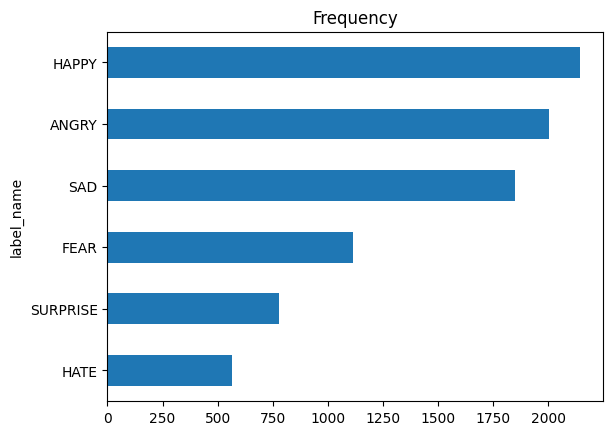

In [ ]:
labele_count.plot.barh()
plt.title ("Frequency")
plt.show()


###  2. Word Count per Class

Next, we analyze the **average number of words** (or tokens) per tweet **for each emotion class**.

This provides insight into:

* How verbose users are when expressing different emotions
* Whether any class tends to have significantly longer or shorter texts

Word count statistics can also guide decisions on:

* Padding/truncation thresholds during tokenization
* Input length constraints for BERT-based models



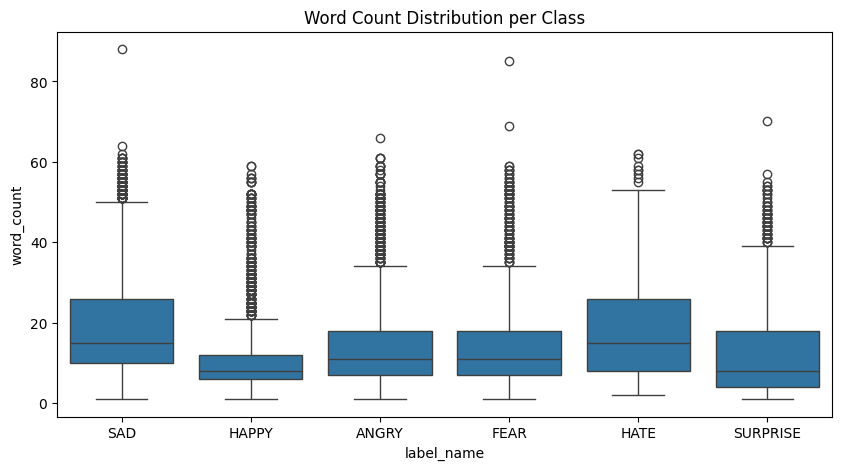

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.boxplot(x="label_name", y="word_count", data=df)
plt.title("Word Count Distribution per Class")
plt.show()

In [ ]:
# Drop after plotting
df.drop(columns=["word_count"], inplace=True)

## 🔀 Step 4: Dataset Splitting & Test Set Preparation

After merging, cleaning, and analyzing the dataset, we proceed to **split the data** for training and validation:

- We **split the merged dataset** into:
  - **Training set:** 90% of the data
  - **Validation set:** 10% of the data

This split ensures we can evaluate model performance on unseen data during training.


In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df,
    test_size=0.1,  # 10% for validation
    random_state=42,  # for reproducibility
    stratify=df['label']  #  maintain class balance
)


###  Special Test Set: ArmanEmo

In addition to the train/validation split, we use the **dedicated ArmanEmo test set** as our final **held-out test data**.

For consistency, we apply the **same text normalization and cleaning pipeline** (as used for training/validation data) on this test set.



In [ ]:
arman_test = pd.read_excel("/content/drive/My Drive/BERT/Data/raw/ArmanEmo/test.xlsx", header=None)
arman_test.columns = ["text", "label_name"]
arman_test = arman_test[arman_test['label_name'] != 'OTHER'].reset_index(drop=True)
arman_test['label'] = arman_test['label_name'].map(label2id)
arman_test.head()

,text,label_name,label
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD,4
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY,2
2,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY,2
3,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD,4
4,به امید موفقیت تیم ملی #ایران و پیروزی در بازی...,HAPPY,2


In [ ]:
arman_test['text'] = arman_test['text'].apply(preprocess_persian_text)

📂 Final DataFrames

At the end of this step, we have:

- `train_df`: Cleaned and preprocessed training set (90%)
- `val_df`: Cleaned and preprocessed validation set (10%)
- `arman_test`: Cleaned and preprocessed ArmanEmo test set for final evaluation

This setup ensures a robust evaluation framework with a clear separation between training, validation, and test phases.


In [ ]:
print('train : ' ,train_df.shape ,
      '\nvalid : ' ,val_df.shape,
      '\ntest : ',arman_test.shape)

train :  (7600, 3) 
valid :  (845, 3) 
test :  (958, 3)


## ⚖️Step 5. Resampling Dataset

To handle class imbalance in the dataset, we initially implemented **resampling techniques** such as oversampling or undersampling.

However, based on experimental results, using a **weighted loss function** during model training proved to be a **much better approach** for managing imbalance in this specific task.

Therefore, while resampling remains an **optional step**, it was **not used in our final best-performing model**.


In [ ]:

"""
from sklearn.utils import resample

# Separate each class by label 0 to 5
class_dfs = {label: train_df[train_df.label == label] for label in range(6)}

# Find max class count dynamically
max_count = max(len(df) for df in class_dfs.values())

balanced_dfs = []
for label in range(6):
    df = class_dfs[label]
    if len(df) < max_count:
        df_up = resample(df, replace=True, n_samples=max_count, random_state=42)
        balanced_dfs.append(df_up)
    else:
        # Already max count or bigger, keep as is
        balanced_dfs.append(df)

train_df_balanced = pd.concat(balanced_dfs)


# 5. Shuffle
train_df_balanced = train_df_balanced.sample(frac=1).reset_index(drop=True)

# Now continue with tokenizer, dataset creation, etc.
"""

In [ ]:
#train_df.shape

In [ ]:
#train_df_balanced.shape

## 💾 Step 6. Convert and Save Datasets

In this step, we convert our cleaned and split Pandas DataFrames into the **Hugging Face `DatasetDict`** format, which is well-suited for training transformer models.

We create a `DatasetDict` containing:

- `'train'`: the training dataset (optionally balanced)
- `'val'`: the validation dataset
- `'test'`: the held-out ArmanEmo test set


In [ ]:
from datasets import Dataset , DatasetDict
dataset = DatasetDict(
    {
        'train' : Dataset.from_pandas(train_df) ,
          'val' : Dataset.from_pandas(val_df),
         'test' : Dataset.from_pandas(arman_test)
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 7600
    })
    val: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 845
    })
    test: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 958
    })
})

In [ ]:
# Remove '__index_level_0__'
dataset['val'] = dataset['val'].remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 7600
    })
    val: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 845
    })
    test: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 958
    })
})

In [ ]:
dataset.save_to_disk("/content/drive/My Drive/BERT/Data/Processed/DatasetDict")

Saving the dataset (0/1 shards):   0%|          | 0/7600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/845 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/958 [00:00<?, ? examples/s]

In [ ]:
train_df.to_csv("/content/drive/My Drive/BERT/Data/Processed/CSV/train.csv")
val_df.to_csv("/content/drive/My Drive/BERT/Data/Processed/CSV/valid.csv")
arman_test.to_csv("/content/drive/My Drive/BERT/Data/Processed/CSV/test.csv")